# Library

In [1]:
import cv2
import numpy as np
from scipy.fft import fftshift, fft2, ifft2
import matplotlib.pyplot as plt

# Load Images

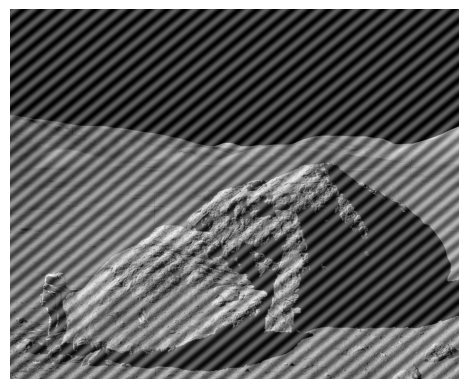

In [2]:
img1 = cv2.imread('astronaut-interference.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.show()

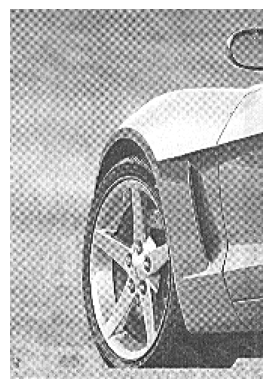

In [3]:
img2 = cv2.imread('car-moire-pattern.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.show()

# Useful Functions

In [9]:
def noise_canceling(image, D0=9, n=4, notch_centers=[(0, 0)], padding='origin', 
                    figsize=(10, 10), plot_result=True):
    # Padding
    padded_image = image.copy()
    if padding == 'zero':
        padded_image = cv2.copyMakeBorder(padded_image, 0, image.shape[0], 0, image.shape[1], 
                                          cv2.BORDER_CONSTANT, value=0)
    if padding == 'replicate':
        padded_image = cv2.copyMakeBorder(padded_image, 0, image.shape[0], 0, image.shape[1], 
                                          cv2.BORDER_REPLICATE)
    if padding == 'constant':
        padded_image = cv2.copyMakeBorder(padded_image, 0, image.shape[0], 0, image.shape[1], 
                                          cv2.BORDER_CONSTANT, value=255)
    if padding == 'reflect':
        padded_image = cv2.copyMakeBorder(padded_image, 0, image.shape[0], 0, image.shape[1], 
                                          cv2.BORDER_REFLECT)
    if padding == 'reflect101':
        padded_image = cv2.copyMakeBorder(padded_image, 0, image.shape[0], 0, image.shape[1], 
                                          cv2.BORDER_REFLECT_101)
    if padding == 'wrap':
        padded_image = cv2.copyMakeBorder(padded_image, 0, image.shape[0], 0, image.shape[1], 
                                          cv2.BORDER_WRAP)
    
    # FFT
    dft = fft2(padded_image)
    dft_shifted = fftshift(dft)  # Shift the zero frequency component to the center
    magnitude_spectrum = np.log(1 + np.abs(dft_shifted))
    
    # Butterworth Notch Filter
    def butterworth_notch_reject_filter(shape, D0, n, centers):
        rows, cols = shape
        u = np.arange(rows)
        v = np.arange(cols)
        u, v = np.meshgrid(u - rows // 2, v - cols // 2, sparse=False, indexing='ij')
        
        # Initialize filter
        filter_mask = np.ones((rows, cols), dtype=np.float32)
        
        for center in centers:
            D = np.sqrt((u - center[0])**2 + (v - center[1])**2)
            D[D == 0] = 1e-10 # avoid division by zero
            
            D_conj = np.sqrt((u + center[0])**2 + (v + center[1])**2)
            D_conj[D_conj == 0] = 1e-10 # avoid division by zero
            filter_mask *= (1 / (1 + (D0 / D)**n)) * (1 / (1 + (D0 / D_conj)**n))
        
        return filter_mask

    # Create the notch filter mask
    notch_filter = butterworth_notch_reject_filter(dft_shifted.shape, D0, n, notch_centers)

    # Apply the filter in the frequency domain
    filtered_dft = dft_shifted * notch_filter
    filtered_magnitude_spectrum = np.log(1 + np.abs(filtered_dft))
    
    # IFFT
    inverse_shifted = np.fft.ifftshift(filtered_dft)
    img_filtered = np.abs(ifft2(inverse_shifted))
     
    # Crop to original image size
    if padding != 'origin':
        original_height, original_width = image.shape
        start_row, start_col = -padded_image.shape[0], 0
        img_filtered = img_filtered[start_row:start_row + original_height, start_col:start_col + original_width]
    
    # Plotting results
    if plot_result:
        plt.figure(figsize=figsize)
        plt.subplot(2, 3, 1), plt.imshow(image, cmap='gray')
        plt.title('Original Image'), plt.axis('off')
        plt.subplot(2, 3, 2), plt.imshow(padded_image, cmap='gray')
        plt.title('Padded Image'), plt.axis('off')
        plt.subplot(2, 3, 3), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Fourier Spectrum'), plt.axis('off')
        plt.subplot(2, 3, 4), plt.imshow(notch_filter, cmap='gray')
        plt.title('Mask Image'), plt.axis('off')
        plt.subplot(2, 3, 5), plt.imshow(filtered_magnitude_spectrum, cmap='gray')
        plt.title('Filtered Spectrum'), plt.axis('off')
        plt.subplot(2, 3, 6), plt.imshow(img_filtered, cmap='gray')
        plt.title('Filtered Image'), plt.axis('off')
        plt.show()
    else:
        return img_filtered

### 1. astronaut-interference.tif

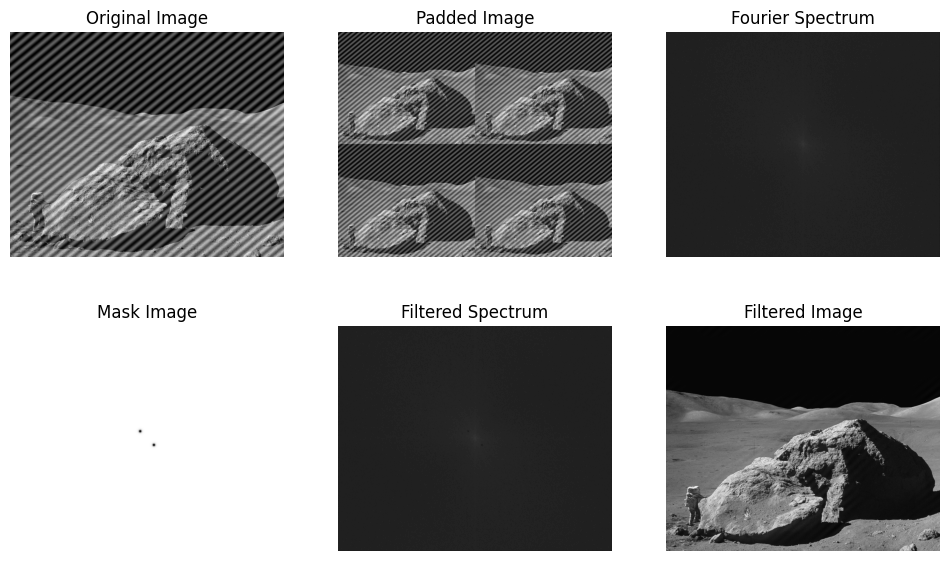

In [5]:
noise_canceling(img1, notch_centers=[(50, 50)], padding='wrap', figsize=(12, 7))

### 2. car-moire-pattern.tif

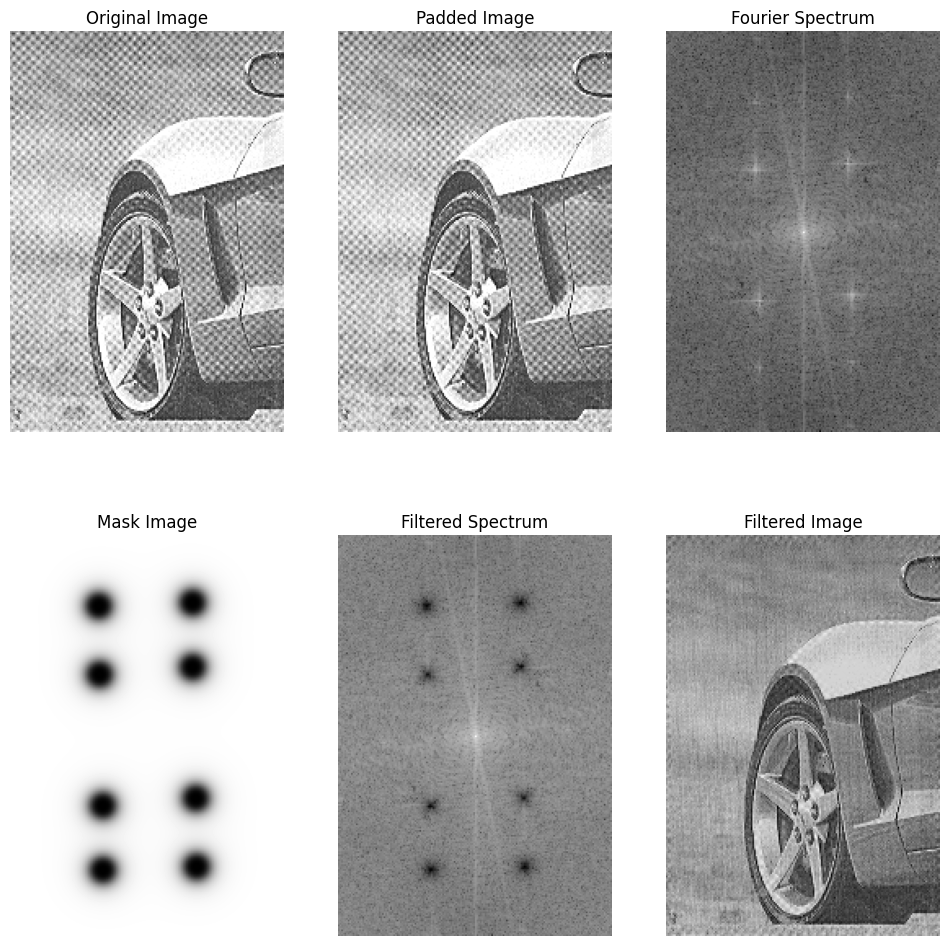

In [6]:
noise_canceling(img2, notch_centers=[(38, 29.5), (-42.5, 27.5), (80, 30), (-82, 27.5)], figsize=(12, 12))

# Appendix

### Different padding methods

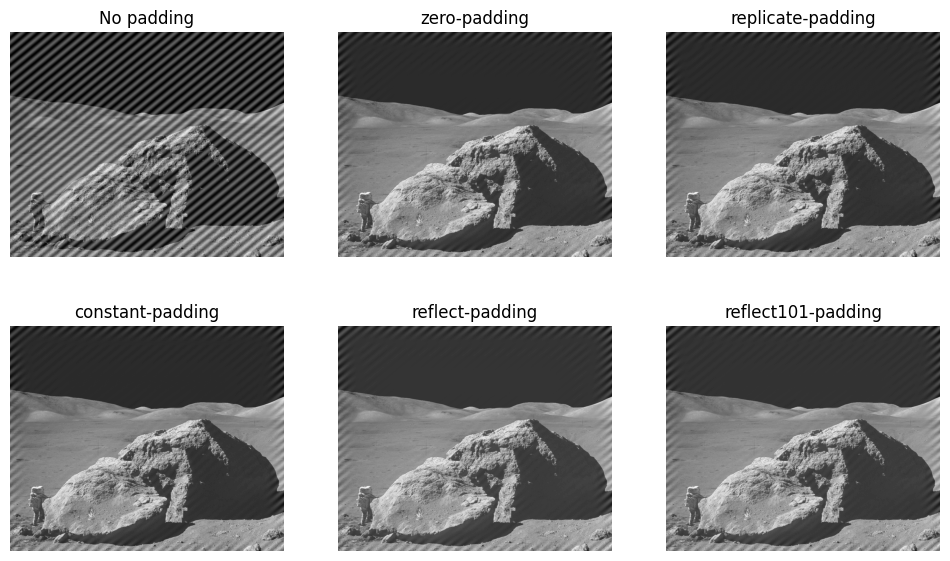

In [7]:
padding_list = ['origin', 'zero', 'replicate', 'constant', 'reflect', 'reflect101']

plt.figure(figsize=(12, 7))
for i in range(len(padding_list)):
    filtered_image = noise_canceling(img1, notch_centers=[(50, 50)], padding=padding_list[i], plot_result=False)
    plt.subplot(2, 3, i + 1), plt.imshow(filtered_image, cmap='gray')
    if padding_list[i] == 'origin':
        plt.title(f"No padding"), plt.axis('off')
    else:
        plt.title(f"{padding_list[i]}-padding"), plt.axis('off')
plt.show()